## Part I: Implement CNN on EMNIST dataset

1. Import Libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import numpy as np
import seaborn as sns
import time
import os



2. Load Dataset

Dataset used: EMNIST (a collection of handwritten digits)

link to paper: https://arxiv.org/pdf/1702.05373

In [2]:
data_dir = './dataset/cnn_dataset'

In [3]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

3. Dataset Visualization and Statistics

In [4]:
print(f"Total samples: {len(dataset)}")
print(f"Number of classes: {len(dataset.classes)}")
print(f"Classes: {dataset.classes}")

Total samples: 100800
Number of classes: 36
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


Class: 0


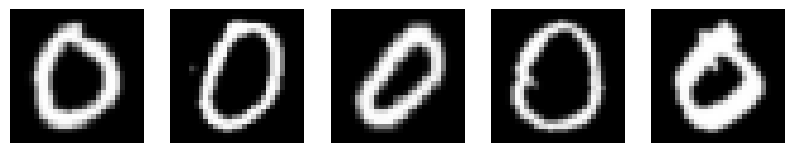

Class: 1


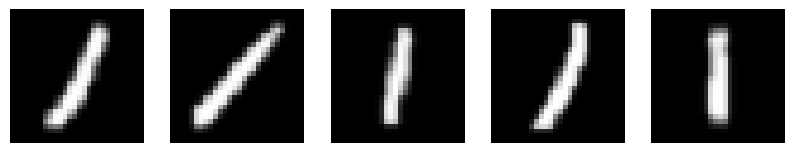

Class: 2


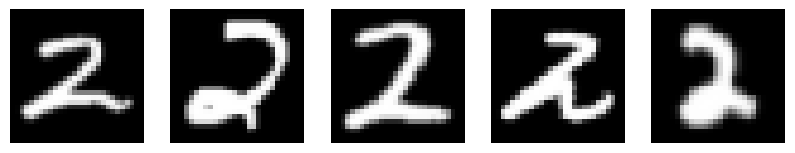

Class: 3


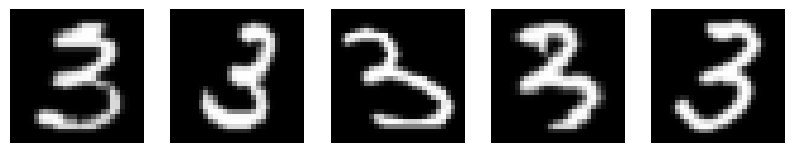

Class: 4


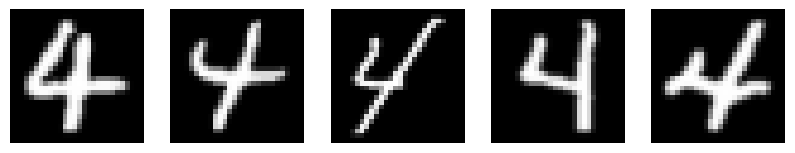

Class: 5


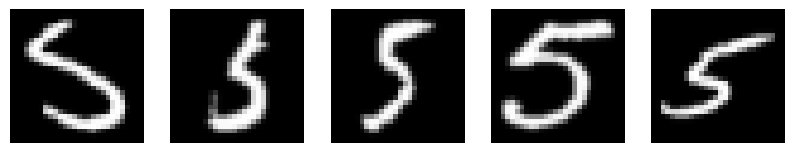

Class: 6


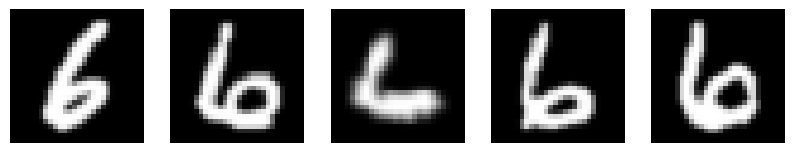

Class: 7


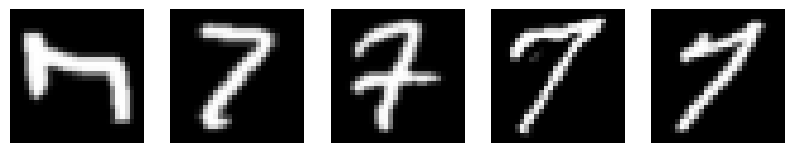

Class: 8


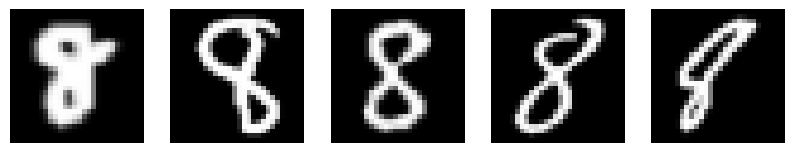

Class: 9


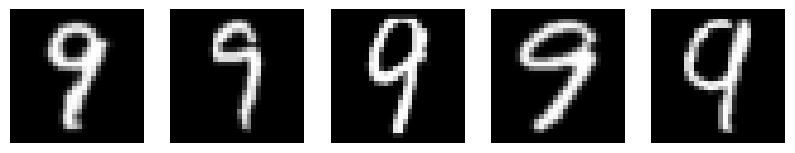

Class: A


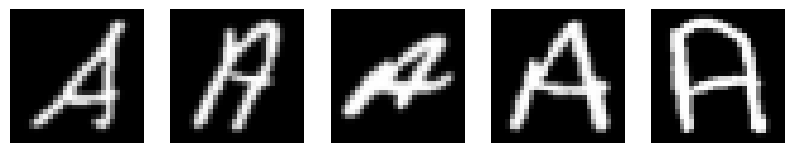

Class: B


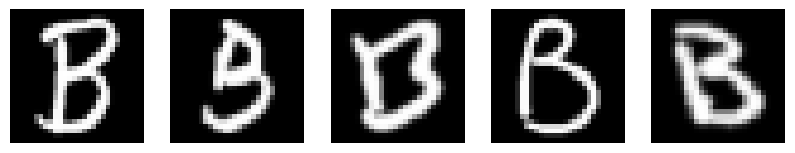

Class: C


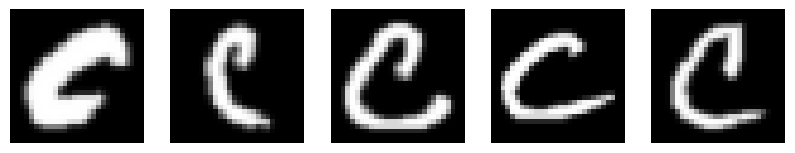

Class: D


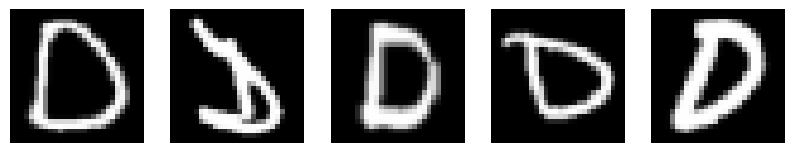

Class: E


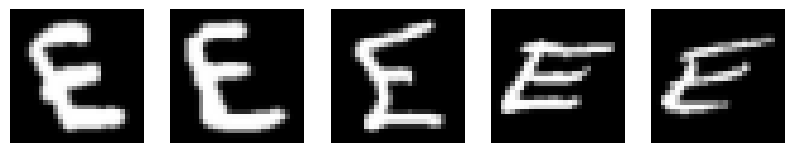

Class: F


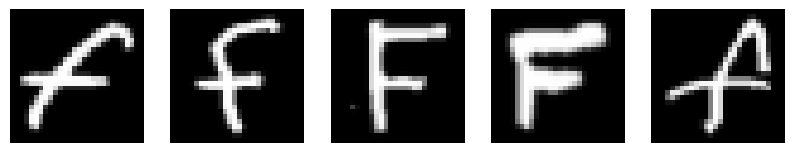

Class: G


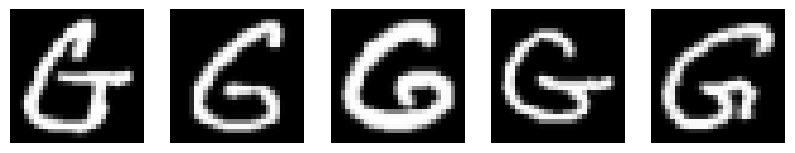

Class: H


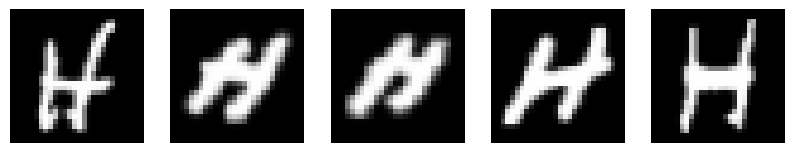

Class: I


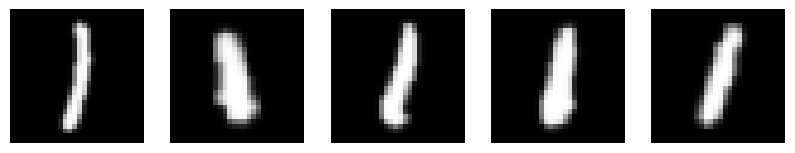

Class: J


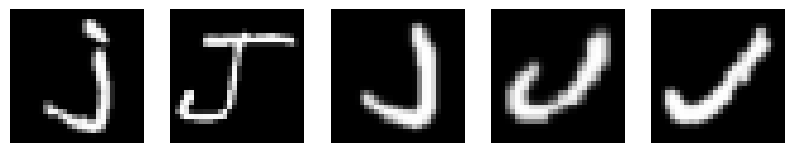

Class: K


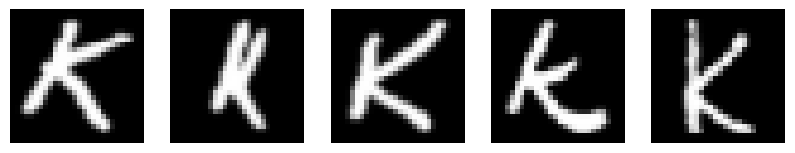

Class: L


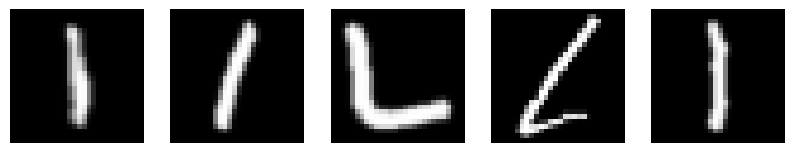

Class: M


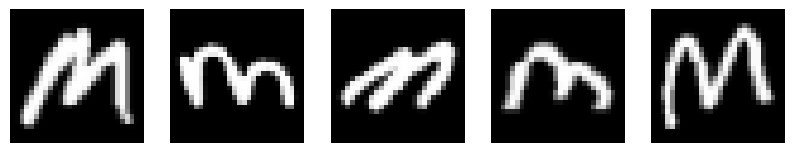

Class: N


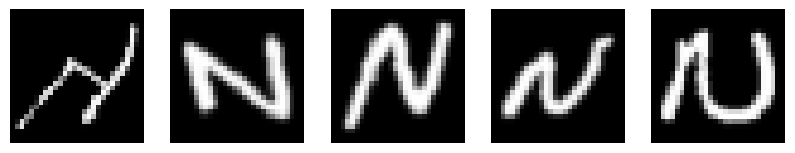

Class: O


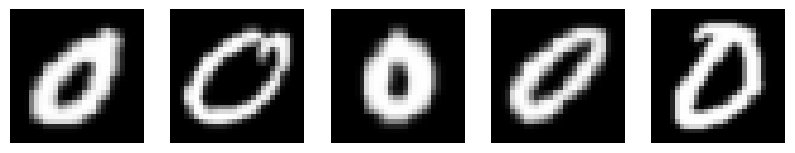

Class: P


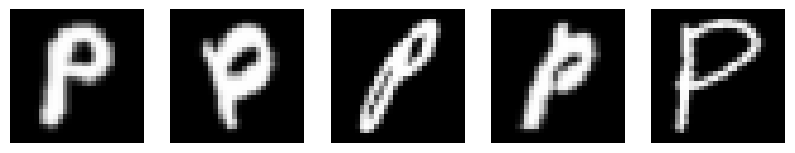

Class: Q


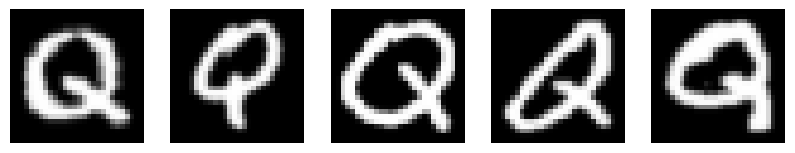

Class: R


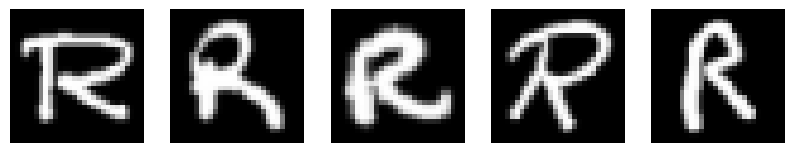

Class: S


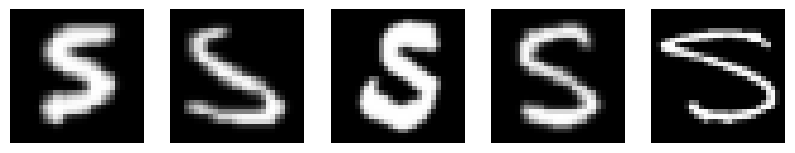

Class: T


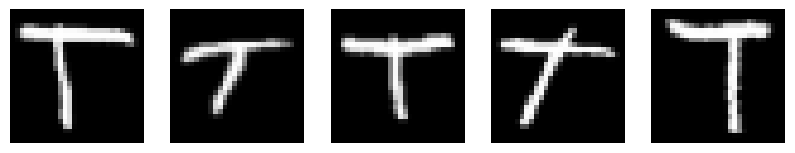

Class: U


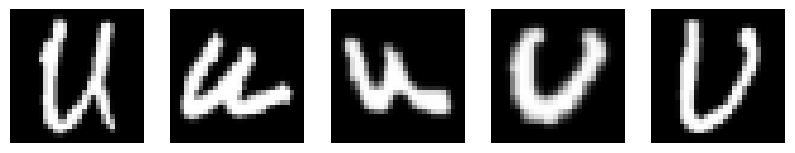

Class: V


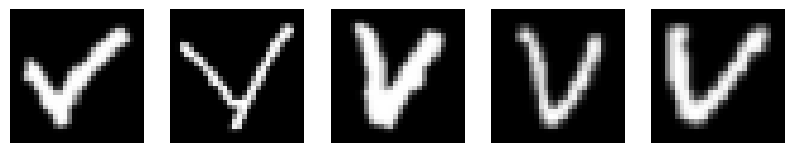

Class: W


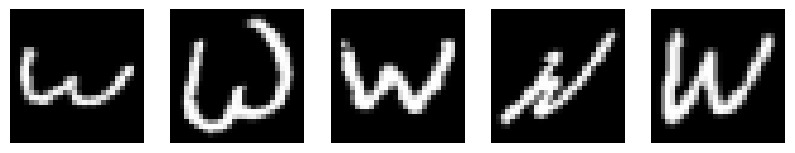

Class: X


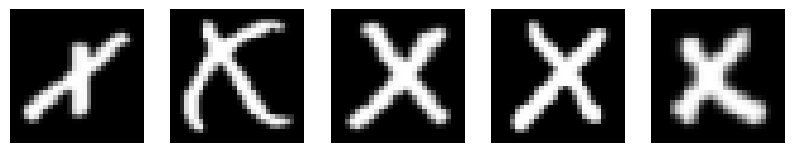

Class: Y


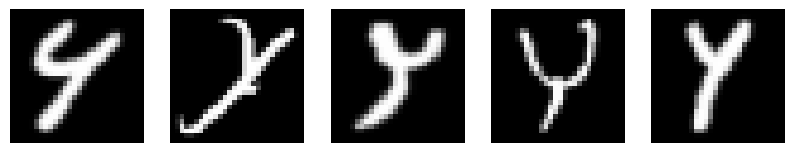

Class: Z


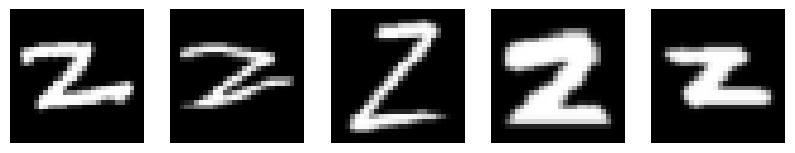

In [5]:
# Map index to class name
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

# Collect 5 samples per class
class_samples = {i: [] for i in range(len(dataset.classes))}

for img, label in dataset:
    if len(class_samples[label]) < 5:
        class_samples[label].append(img)
    if all(len(samples) == 5 for samples in class_samples.values()):
        break

# Plot 5 images per class (28x28 grayscale)
for class_idx, images in class_samples.items():
    class_name = idx_to_class[class_idx]
    print(f"Class: {class_name}")
    fig, axs = plt.subplots(1, 5, figsize=(10, 2))
    for i, img in enumerate(images):
        axs[i].imshow(img.squeeze(), cmap='gray')  # squeeze to remove channel dim
        axs[i].axis('off')
    plt.show()

Computing class averages: 100%|██████████| 100800/100800 [00:09<00:00, 10231.20it/s]


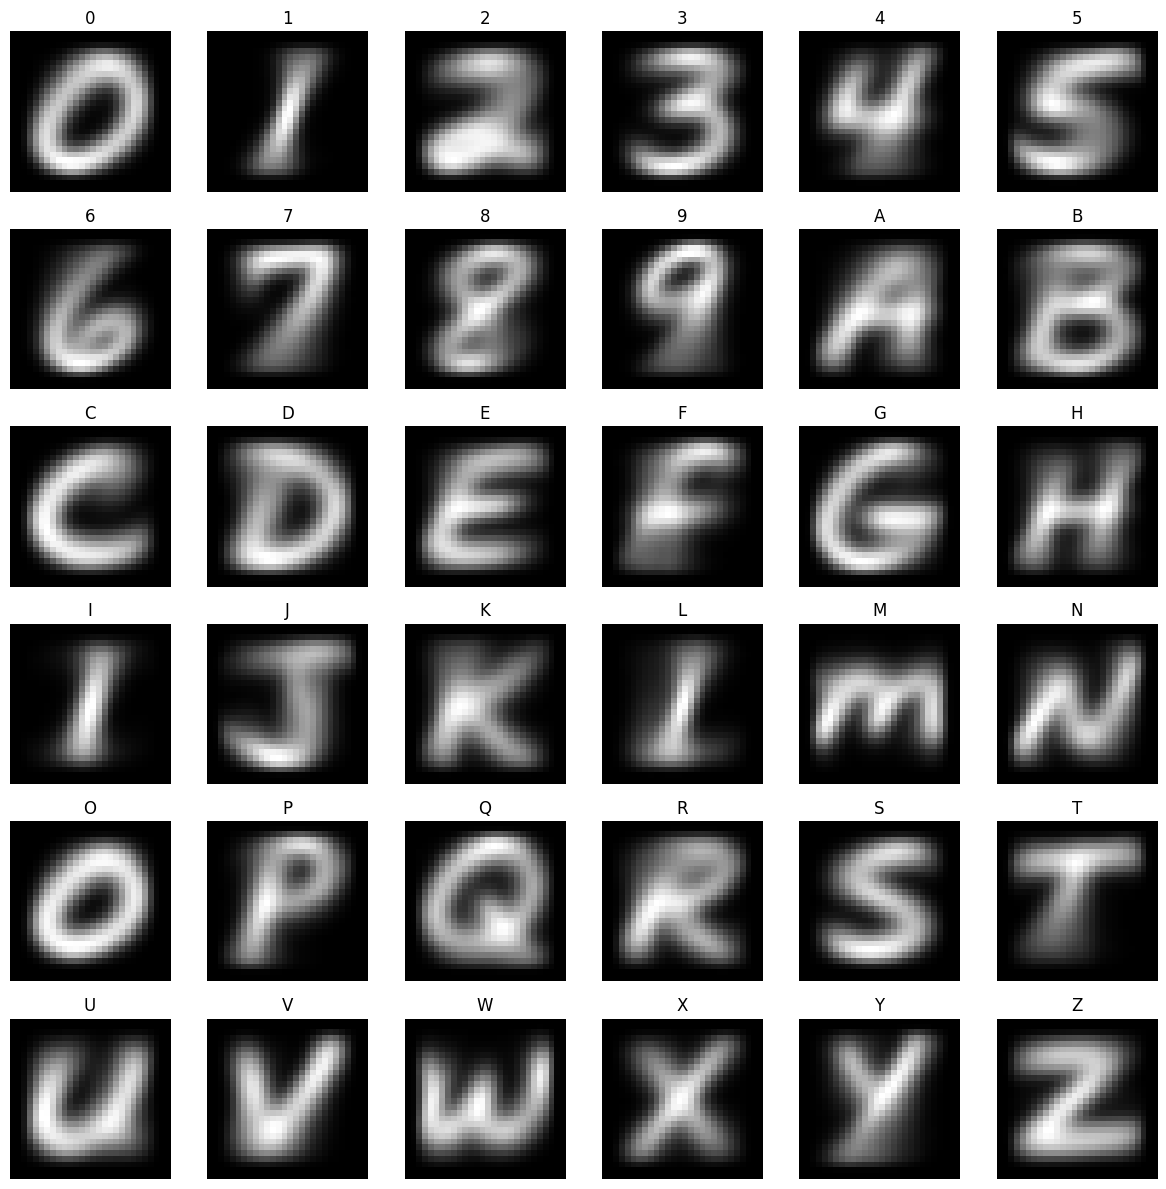

In [6]:
# Print average image representation from each class

# Initialize accumulators
num_classes = len(dataset.classes)
class_sums = [torch.zeros((1, 28, 28)) for _ in range(num_classes)]
class_counts = [0 for _ in range(num_classes)]
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

# Accumulate pixel values
for img, label in tqdm(dataset, desc="Computing class averages"):
    class_sums[label] += img
    class_counts[label] += 1

# Compute average image per class
class_averages = [class_sums[i] / class_counts[i] for i in range(num_classes)]

# Plot average image per class
num_cols = 6
num_rows = (num_classes + num_cols - 1) // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 2 * num_rows))

for i in range(num_classes):
    row, col = divmod(i, num_cols)
    ax = axs[row][col] if num_rows > 1 else axs[col]
    ax.imshow(class_averages[i].squeeze(), cmap='gray')
    ax.set_title(f"{idx_to_class[i]}")
    ax.axis('off')

# Hide empty subplots if any
for j in range(num_classes, num_rows * num_cols):
    row, col = divmod(j, num_cols)
    ax = axs[row][col] if num_rows > 1 else axs[col]
    ax.axis('off')

plt.tight_layout()
plt.show()


4. Split dataset into training, test and validation sets

In [7]:
# Split the dataset into train+val and test sets
train_val_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_val_size
train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size])

# Split the train+val set into train and validation sets
train_size = int(0.889 * train_val_size)
val_size = train_val_size - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

In [8]:
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 80650
Validation samples: 10070
Testing samples: 10080


In [9]:
# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

5. Define the CNN model

In [10]:
# Define the CNN model - 5 hidden layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # Conv layer 1 : nn.Conv2d(in_channels, out_channels, kernel_size,  padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # Conv layer 1
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1) # Conv layer 1
        self.pool = nn.MaxPool2d(2, 2)  # Max pool
        self.fc1 = nn.Linear(64 * 3 * 3, 128) # FC1
        self.fc2 = nn.Linear(128, len(dataset.classes)) # FC2
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net()

summary(model, input_size=(batch_size, 1, 28, 28)) # Print summary of CNN - (batch_size, num_channels, height, width)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [64, 36]                  --
├─Conv2d: 1-1                            [64, 32, 28, 28]          320
├─MaxPool2d: 1-2                         [64, 32, 14, 14]          --
├─Conv2d: 1-3                            [64, 64, 14, 14]          18,496
├─MaxPool2d: 1-4                         [64, 64, 7, 7]            --
├─Conv2d: 1-5                            [64, 64, 7, 7]            36,928
├─MaxPool2d: 1-6                         [64, 64, 3, 3]            --
├─Linear: 1-7                            [64, 128]                 73,856
├─Dropout: 1-8                           [64, 128]                 --
├─Linear: 1-9                            [64, 36]                  4,644
Total params: 134,244
Trainable params: 134,244
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 368.90
Input size (MB): 0.20
Forward/backward pass size (MB): 20.96
Params size (MB): 0.54
Estimated T

In [11]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

Using device: mps


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=36, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

6. Training Loop

In [12]:
def train_model(model, num_epochs, optimizer, criterion, scheduler, train_loader, val_loader, device, model_path, patience=False):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_loss = float('inf')  # Assigned to infinity (large number)
    start_time = time.time()  

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss, correct, total = 0.0, 0, 0

        # Mini batch gradient descent
        for batch_X, batch_y in tqdm(train_loader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(batch_X)  # Forward pass
            loss = criterion(outputs, batch_y.squeeze().long())  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model weights

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get class predictions
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

        scheduler.step()  # Adjust learning rate

        train_loss /= len(train_loader)
        train_accuracy = correct / total


        # Validation Phase
        model.eval()  # Set model to evaluation mode
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y.squeeze().long())

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == batch_y).sum().item()
                total += batch_y.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct / total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1  # Increase patience counter

        # Early stopping
        if patience and patience_counter >= 5:
            print(f"Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}")
            break


    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds")
    
    return train_losses, val_losses, train_accuracies, val_accuracies
 


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5 )
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 30
model_path = "best_emnist_model.pth"

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, num_epochs, optimizer, criterion, scheduler, train_loader, val_loader, device, model_path, patience=True
    )

100%|██████████| 1261/1261 [00:24<00:00, 51.16it/s]


Epoch 1/30, Train Loss: 0.8954, Val Loss: 0.3500, Train Acc: 0.7139, Val Acc: 0.8718


100%|██████████| 1261/1261 [00:24<00:00, 52.31it/s]


Epoch 2/30, Train Loss: 0.4541, Val Loss: 0.3024, Train Acc: 0.8438, Val Acc: 0.8877


100%|██████████| 1261/1261 [00:24<00:00, 51.44it/s]


Epoch 3/30, Train Loss: 0.3904, Val Loss: 0.2858, Train Acc: 0.8626, Val Acc: 0.8910


100%|██████████| 1261/1261 [00:24<00:00, 51.56it/s]


Epoch 4/30, Train Loss: 0.3552, Val Loss: 0.2801, Train Acc: 0.8741, Val Acc: 0.8958


100%|██████████| 1261/1261 [00:24<00:00, 51.83it/s]


Epoch 5/30, Train Loss: 0.3305, Val Loss: 0.2670, Train Acc: 0.8816, Val Acc: 0.8998


100%|██████████| 1261/1261 [00:24<00:00, 50.79it/s]


Epoch 6/30, Train Loss: 0.2742, Val Loss: 0.2435, Train Acc: 0.8998, Val Acc: 0.9097


100%|██████████| 1261/1261 [00:24<00:00, 50.92it/s]


Epoch 7/30, Train Loss: 0.2596, Val Loss: 0.2405, Train Acc: 0.9051, Val Acc: 0.9105


100%|██████████| 1261/1261 [00:24<00:00, 50.73it/s]


Epoch 8/30, Train Loss: 0.2541, Val Loss: 0.2410, Train Acc: 0.9076, Val Acc: 0.9119


100%|██████████| 1261/1261 [00:25<00:00, 49.70it/s]


Epoch 9/30, Train Loss: 0.2459, Val Loss: 0.2381, Train Acc: 0.9098, Val Acc: 0.9123


100%|██████████| 1261/1261 [00:25<00:00, 49.65it/s]


Epoch 10/30, Train Loss: 0.2436, Val Loss: 0.2380, Train Acc: 0.9096, Val Acc: 0.9129


100%|██████████| 1261/1261 [00:25<00:00, 50.27it/s]


Epoch 11/30, Train Loss: 0.2365, Val Loss: 0.2360, Train Acc: 0.9128, Val Acc: 0.9133


100%|██████████| 1261/1261 [00:24<00:00, 50.86it/s]


Epoch 12/30, Train Loss: 0.2357, Val Loss: 0.2357, Train Acc: 0.9119, Val Acc: 0.9137


100%|██████████| 1261/1261 [00:25<00:00, 49.90it/s]


Epoch 13/30, Train Loss: 0.2366, Val Loss: 0.2355, Train Acc: 0.9130, Val Acc: 0.9140


100%|██████████| 1261/1261 [00:24<00:00, 50.78it/s]


Epoch 14/30, Train Loss: 0.2339, Val Loss: 0.2353, Train Acc: 0.9132, Val Acc: 0.9139


100%|██████████| 1261/1261 [00:25<00:00, 50.00it/s]


Epoch 15/30, Train Loss: 0.2308, Val Loss: 0.2355, Train Acc: 0.9148, Val Acc: 0.9140


100%|██████████| 1261/1261 [00:24<00:00, 50.51it/s]


Epoch 16/30, Train Loss: 0.2322, Val Loss: 0.2354, Train Acc: 0.9146, Val Acc: 0.9136


100%|██████████| 1261/1261 [00:24<00:00, 50.45it/s]


Epoch 17/30, Train Loss: 0.2338, Val Loss: 0.2353, Train Acc: 0.9135, Val Acc: 0.9136


100%|██████████| 1261/1261 [00:24<00:00, 51.11it/s]


Epoch 18/30, Train Loss: 0.2331, Val Loss: 0.2352, Train Acc: 0.9138, Val Acc: 0.9133


100%|██████████| 1261/1261 [00:24<00:00, 51.30it/s]


Epoch 19/30, Train Loss: 0.2304, Val Loss: 0.2351, Train Acc: 0.9140, Val Acc: 0.9132


100%|██████████| 1261/1261 [00:24<00:00, 51.94it/s]


Epoch 20/30, Train Loss: 0.2340, Val Loss: 0.2351, Train Acc: 0.9138, Val Acc: 0.9134


100%|██████████| 1261/1261 [00:24<00:00, 51.01it/s]


Epoch 21/30, Train Loss: 0.2346, Val Loss: 0.2351, Train Acc: 0.9131, Val Acc: 0.9133


100%|██████████| 1261/1261 [00:25<00:00, 49.98it/s]


Epoch 22/30, Train Loss: 0.2324, Val Loss: 0.2351, Train Acc: 0.9144, Val Acc: 0.9132


100%|██████████| 1261/1261 [00:24<00:00, 52.03it/s]


Epoch 23/30, Train Loss: 0.2329, Val Loss: 0.2351, Train Acc: 0.9135, Val Acc: 0.9133


100%|██████████| 1261/1261 [00:24<00:00, 50.84it/s]


Epoch 24/30, Train Loss: 0.2324, Val Loss: 0.2351, Train Acc: 0.9137, Val Acc: 0.9133


100%|██████████| 1261/1261 [00:24<00:00, 50.48it/s]


Epoch 25/30, Train Loss: 0.2353, Val Loss: 0.2351, Train Acc: 0.9130, Val Acc: 0.9133


100%|██████████| 1261/1261 [00:24<00:00, 50.66it/s]


Epoch 26/30, Train Loss: 0.2320, Val Loss: 0.2351, Train Acc: 0.9141, Val Acc: 0.9133


100%|██████████| 1261/1261 [00:25<00:00, 50.04it/s]


Epoch 27/30, Train Loss: 0.2332, Val Loss: 0.2351, Train Acc: 0.9141, Val Acc: 0.9133


100%|██████████| 1261/1261 [00:24<00:00, 50.80it/s]


Epoch 28/30, Train Loss: 0.2320, Val Loss: 0.2351, Train Acc: 0.9138, Val Acc: 0.9134


100%|██████████| 1261/1261 [00:25<00:00, 49.71it/s]


Epoch 29/30, Train Loss: 0.2341, Val Loss: 0.2351, Train Acc: 0.9131, Val Acc: 0.9134


100%|██████████| 1261/1261 [00:24<00:00, 51.09it/s]


Epoch 30/30, Train Loss: 0.2327, Val Loss: 0.2351, Train Acc: 0.9142, Val Acc: 0.9134
Training completed in 820.61 seconds


7. Evaluate on test data

In [14]:
model.load_state_dict(torch.load(model_path))
model.eval()

test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2f}%')
print(f'Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}')

/var/folders/xs/nhb_5fz94td50ytsrsq2jc9h0000gn/T/ipykernel_7048/14429904.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Loss: 0.230, Test Accuracy: 91.89%
Precision: 0.920, Recall: 0.919, F1 Score: 0.918


8. Plot: Training and Validation Loss vs Epoch

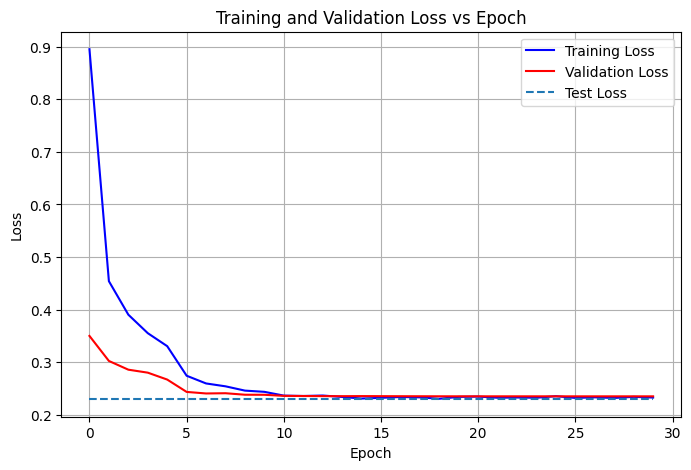

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="red")
plt.plot([test_loss]*num_epochs, label='Test Loss', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.show()